In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from collections import Counter as ct
plt.rcParams['figure.figsize'] = (8,5)
%matplotlib inline

In [216]:
data_train = pd.read_csv('../practice/house_price/train.csv')
data_test = pd.read_csv('../practice/house_price/test.csv')

In [217]:
# For describing numerical columns and drawing histograms
def descr(x):
    la = x.columns[x.isnull().any()].tolist()
    data_train_numeric_col = x._get_numeric_data().columns.tolist()
    df_cols = []
    for i in la:
        if i in data_train_numeric_col:
            df_cols.append(i)
            b = x[i].isnull().value_counts()
            print("Name of Column", i + ":\nNumber of Null values:\n",b)
    df = x[df_cols]
    print(df.describe())
    return df.hist()

Name of Column LotFrontage:
Number of Null values:
 False    1201
True      259
Name: LotFrontage, dtype: int64
Name of Column MasVnrArea:
Number of Null values:
 False    1452
True        8
Name: MasVnrArea, dtype: int64
Name of Column GarageYrBlt:
Number of Null values:
 False    1379
True       81
Name: GarageYrBlt, dtype: int64
       LotFrontage   MasVnrArea  GarageYrBlt
count  1201.000000  1452.000000  1379.000000
mean     70.049958   103.685262  1978.506164
std      24.284752   181.066207    24.689725
min      21.000000     0.000000  1900.000000
25%      59.000000     0.000000  1961.000000
50%      69.000000     0.000000  1980.000000
75%      80.000000   166.000000  2002.000000
max     313.000000  1600.000000  2010.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb81c48630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7feb81b3d630>]], dtype=object)

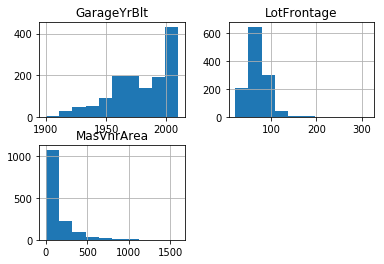

In [218]:
descr(data_train)

In [219]:
# For Na value filling of MasVnrArea column
def fill_na_mean(x, y):
    x[y] = x[y].fillna(np.round(np.mean(x[y])))

In [220]:
fill_na_mean(data_train, 'MasVnrArea')

In [221]:
# For filling na with range of random values
def fill_na_range(A, B, x,y):
    a = range(x,y)
    c = A[B].isnull()
    A[B] = A[B].fillna(pd.Series(np.random.choice(a, size=A.shape[0])))

In [222]:
fill_na_range(data_train, 'LotFrontage', 50, 100)

In [223]:
fill_na_range(data_train, 'GarageYrBlt', 1960, 2000)

In [224]:
#rand_range = [i for i in range(40,100)]
#data_train['LotFrontage'] = data_train['LotFrontage'].fillna(pd.Series(np.random.choice(rand_range,size=data_train.shape[0])))

In [225]:
# To check the Na values
def is_na(x,y):
    return x[y].isnull().value_counts()

is_na(data_train,'GarageYrBlt')

False    1460
Name: GarageYrBlt, dtype: int64

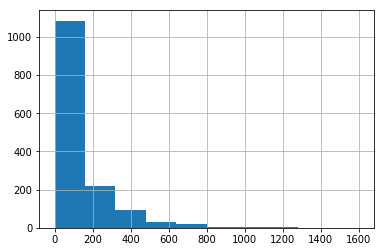

In [226]:
data_train.MasVnrArea.hist()

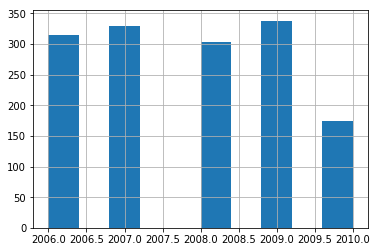

In [227]:
data_train.YrSold.hist()

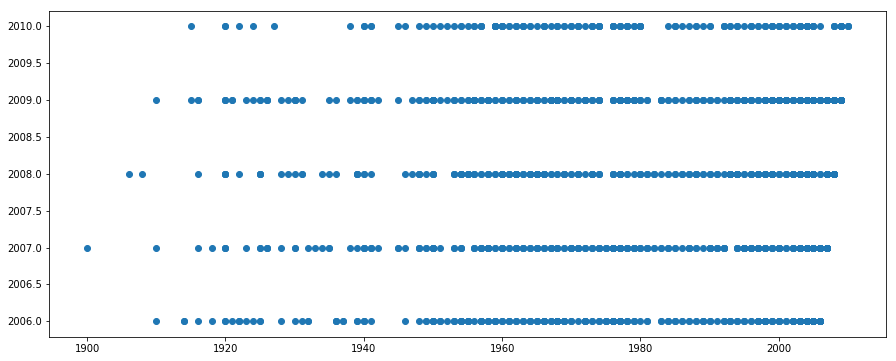

In [228]:
# Here we are checking if filled GarageYrBlt na values are not greater than YrSold
#(data_train.YearBuilt > data_train.YrSold).value_counts()
plt.figure(figsize=(15,6))
plt.scatter(data_train.GarageYrBlt, data_train.YrSold)

In [229]:
data_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [230]:
(data_train.YearRemodAdd > data_train.YrSold).value_counts()

False    1459
True        1
dtype: int64

In [231]:
# This data point does not affect sale price
# We shall handle this situation by taking only positive value.
y = data_train[(data_train.YearRemodAdd > data_train.YrSold)]
y[['YearRemodAdd', 'YrSold']]

,YearRemodAdd,YrSold
523,2008,2007


In [232]:
(data_train.YearRemodAdd < data_train.YearBuilt).value_counts()

False    1460
dtype: int64

In [233]:
data_train['buit_sold_diff'] = data_train.YrSold - data_train.YearBuilt
data_train['built_remod_diff'] = data_train.YearRemodAdd - data_train.YearBuilt
data_train['remod_sold_diff'] = data_train.YrSold - data_train.YearRemodAdd

In [234]:
# Categorical columns
columns = data_train.columns
numeric_cols = data_train._get_numeric_data().columns
categorical_cols = list(set(columns) - set(numeric_cols))

In [235]:
# Here we are checking if there are any columns with only binary values
binary_cols = []
for i in categorical_cols:
    if data_train[i].nunique() == 2:
        binary_cols.append(i)
        print(i)

CentralAir
Street
Alley
Utilities


In [236]:
# Equivalent to --->data_train['CentralAir'] = np.where(data_train['CentralAir'] == 'Y', 1, data_train['CentralAir'])
# --->data_train['CentralAir'] = np.where(data_train['CentralAir'] == 'N', 0, data_train['CentralAir'])
# We are doing this to reduce number of features

def binary_coding(a, b):
    a[b] = np.where(a[b] == a[b].unique()[0], 1, a[b])
    a[b] = np.where(a[b] == a[b].unique()[1], 0, a[b])

In [237]:
binary_coding(data_train, 'Street')
binary_coding(data_train, 'CentralAir')
binary_coding(data_train, 'Utilities')

In [238]:
for i in binary_cols:
    if i != 'Alley':
        categorical_cols.remove(i)

In [239]:
# We have checked if any row is a duplicate of any other row
data_train[data_train.duplicated(keep=False)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,buit_sold_diff,built_remod_diff,remod_sold_diff


In [240]:
del data_train['YearBuilt']
del data_train['YrSold']
del data_train['YearRemodAdd']

In [241]:
dummy_data = pd.get_dummies(data=data_train, columns=categorical_cols)

In [242]:
dummy_data.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,...,GarageFinish_RFn,GarageFinish_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,1,60,65.0,8450,1,1,7,5,196.0,706,...,1,0,0,0,0,1,0,0,0,0
1,2,20,80.0,9600,1,1,6,8,0.0,978,...,1,0,0,0,0,1,0,0,0,0
2,3,60,68.0,11250,1,1,7,5,162.0,486,...,1,0,0,0,0,1,0,0,0,0
3,4,70,60.0,9550,1,1,7,5,0.0,216,...,0,1,0,0,0,1,0,0,0,0
4,5,60,84.0,14260,1,1,8,5,350.0,655,...,1,0,0,0,0,1,0,0,0,0


In [243]:
dummy_data[dummy_data['remod_sold_diff'] == -1]

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,...,GarageFinish_RFn,GarageFinish_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
523,524,60,130.0,40094,1,1,10,5,762.0,2260,...,0,0,0,0,0,1,0,0,0,0


In [244]:
dummy_data['remod_sold_diff'] = np.absolute(dummy_data['remod_sold_diff'])

In [247]:
# So we have successfully converted our data to numerical form, suitable for regression
# There are no na values.
dummy_data.isnull().any().value_counts()

False    287
dtype: int64